<a target="_blank" href="https://colab.research.google.com/github/TinArmEngineering/ltc_internal_examples/blob/main/Example_1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    with open('requirements.txt', 'w') as fout:
        fout.write("""ltc_client>=0.2.3
        pint
        pandas
        pint-pandas
        matplotlib
        pyyaml
        scipy
        openpyxl""")
except:
    IN_COLAB = False
    

In [2]:
%%capture --no-display
!pip install -r requirements.txt


In [3]:
import matplotlib.pyplot as plt
import ltc_client
import logging
import time
import yaml
import pandas as pd
import pint_pandas
import numpy as np


/home/mjfwest/repositories/ltc_internal_examples/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Starting up
Log into the website for Tin Arm Engineering's machine solver, and under profile, retrieve your API key, and optionaly, the organisation id that you wish to use.  
Do not commit your API key to a repository, and consider it like a password.  There are a few good ways to keep it out of the code base. If I am developing locally I use a configuation file, or environment variable.  If running on Google's [colab](https://colab.research.google.com/) you can use `from google.colab import userdata`. We will want other things cofigured too, so let's use a yaml file for convenience. 

create a `configurations.yaml` file in this directory with the content.
```yaml
api_key: 8b6565701741b979645986b3999e0*** # This is your API key, retrieve it from your account page
org_id: 664c7a32082dfb8e39e30*** # This is your organization ID, retrieve it from your account page
root_url: https://api.ltc.tinarmengineering.com # This is your root URL for the BUILD server, eventually this will be the URL for the Production server
queue_url: wss://queue.ltc.tinarmengineering.com:15671/ws # This is the webscoket URL for the RabbitMQ server, again eventually this will be the URL for the Production rabbitMQserver
queue_user: t**** #  this is a temporary username for the RabbitMQ server, we will soon have better solution for this
queue_password: U*** # this is a temporary password for the RabbitMQ server, we will soon have better solution for this
datasheet_path: <path somewhere>/SteelDataSheets/ # This is the path to the Steel Data Sheets, used in some examples
results_path: <path somewhere>/Presentations/ # This is the path to where you wan't your results stored.
```
But of course replace the paths and *** with your keys, and passwords. 

You can then add that file to your `.gitignore` file by executing ```echo 'configurations.yaml' >> .gitignore```  this will help prevent accitdents.  

```
!echo 'configurations.yaml' >> .gitignore
```

In [4]:
# are we running in google colab?
if IN_COLAB:
    from google.colab import userdata
    
    print("Running in Google Colab")
    config = {'root_url': "https://api.ltc.tinarmengineering.com",
              'queue_url':"wss://queue.ltc.tinarmengineering.com:15671/ws",
              'api_key': userdata.get("api_key"),
              'org_id': userdata.get("org_id"),
              'queue_user': userdata.get("queue_user"),
              'queue_password': userdata.get("queue_password")}
else:
    
    print("Running locally")
    with open("configurations.yaml", "r") as f:
        config = yaml.safe_load(f)


Running locally


## Configure logging
There are many ways to do this, refer to the internet

In [5]:
LOGGING_LEVEL = logging.INFO
### Configure Logging
logger = logging.getLogger()
logger.setLevel(LOGGING_LEVEL)
ch = logging.StreamHandler()
ch.setLevel(LOGGING_LEVEL)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)

logger.info(f"tinarm version {ltc_client.__version__}")
logger.info(f"pint_pandas version {pint_pandas.__version__}")


2024-07-05 10:41:08,831 - root - INFO - tinarm version 0.2.3
2024-07-05 10:41:08,831 - root - INFO - pint_pandas version 0.6
2024-07-05 10:41:08,831 - root - INFO - pint_pandas version 0.6


## Uinit Handling. 
The API enforces correct units to avoid ambiguity and errors. This is made easy as the API is compatible with [Pint](https://pint.readthedocs.io/en/stable/) and  Pint-Pandas unit handling libraries.  

In [6]:

q = pint_pandas.PintType.ureg
q.setup_matplotlib()

## Set up the machine. 
We will do a simulation of a concentrated wound fractional slot machine, we will get on to how to design the machine later.  The machine is comprised of:
1. the stator, and a 
2. rotor, 
3. and the winding parameters 
### Stator
The tooth wound stator is parameterised by the following dictionary of parameters. 

In [7]:
air_gap_length = 1 * q.mm

stator_parameters = {
    "slot_liner_thickness": 300 * q.um,
    "stator_bore": 8.20 * q.cm,
    "tooth_tip_depth": 1.0 * q.mm,
    "slot_opening": 1.5 * q.mm,
    "tooth_width": 9.8 * q.mm,
    "stator_outer_diameter": 0.136 * q.m,
    "back_iron_thickness": 5.5 * q.mm,
    "stator_internal_radius": 500 * q.um,
    "number_slots": 12 * q.count,
    "tooth_tip_angle": 70 * q.degrees
    }



### Rotor
A suitable rotor for this machine is a Surface Mounted rotor with Breadloaf Magnets.  It is parameterised by the following dictionary. We've used the variable `air_gap_length' to link the rotor_od to the stator bore.


In [8]:
rotor_parameters = {
    "rotor_od": stator_parameters["stator_bore"] - 2 * air_gap_length,
    "rotor_bore": 40 * q.mm,
    "banding_thickness": 0.5 * q.mm,
    "number_poles": 10 * q.count,
    "magnet_thickness": 4.5 * q.millimeter,
    "magnet_pole_arc": 150 * q.degrees,
    "magnet_inset": 0.25 * q.millimeter
    }

## Winding
The winding is described by the winding parametrs.  These need further explanation.  The parameter symmetry sets the degrees of symmetry used in the simulation. 

In [9]:
# calculate the GCD of the number of slots and the number of poles
symmetry = np.gcd(stator_parameters["number_slots"].magnitude, rotor_parameters["number_poles"].magnitude) * q.count
symmetry

<Quantity(2, 'count')>

In [10]:
winding_parameters = {
    "symmetry": symmetry,
    "number_phases": 3 * q.count,
    "number_layers": 2 * q.count,
    "coil_span": 1 * q.count,
    "turns_per_coil": 43 * q.count,
    "empty_slots": 0 * q.count,
    "fill_factor": 42 * q.percent
    }

Finally create the Machine using the class `ltc_client.Machine`. This will initialise it with default materials.  We will change the materials later. 

In [11]:
our_machine = ltc_client.Machine(stator_parameters, rotor_parameters, winding_parameters)

for key, value in our_machine.materials.items():
    print(f"{key}: {value}")

rotor_lamination: 66018e5d1cd3bd0d3453646f
rotor_magnet: 66018e5b1cd3bd0d3453646c
rotor_air_L: 6602fb42c4a87c305481e8a6
rotor_air_R: 6602fb42c4a87c305481e8a6
rotor_banding: 6602fb42c4a87c305481e8a6
stator_lamination: 66018e5d1cd3bd0d3453646f
stator_slot_wedge: 6602fb7239bfdea291a25dd7
stator_slot_liner: 6602fb5166d3c6adaa8ebe8c
stator_slot_winding: 66018e5d1cd3bd0d34536470
stator_slot_potting: 6602fd41b8e866414fe983ec


## Set up the simulation job
The simulation job is made up of a `Machine`, the opperating points, and the simulation parameters.

The Simulation Parameters control the length of the simulation and the number of transient timesteps. To calculate the ironloss we need to simulate over one full electrical period.   We also set the active length here as it is a 2d simulation. 

In [12]:
simulation_parameters = {
       "samples_per_electrical_period": 180 * q.count/q.turn,
        "timestep_intervals": 180 * q.count,
        "active_length": 65 * q.mm }


## Operating Point
We will set off two simultanious simulation jobs, an open circut simulation with 0 current, and the nominal opperating point with a q axis current density of 6.23 $A/mm^{2}$.  We will have 2 simulation jobs

In [13]:
op_open_cct = {
    "simulated_speed": 2060 * q.rpm,
    "q_axis_current_density": 0 * q.A / q.mm ** 2,
    "d_axis_current_density": 0 * q.A / q.mm ** 2,
    "current_angle": 0 * q.degrees
    }

op_nominal = {
    'q_axis_current_density': 6.23 * q.A * q.mm**-2,
    "d_axis_current_density": 0 * q.A / q.mm ** 2,
    'current_angle': 255 * q.degrees,
    "simulated_speed": 2060 * q.rpm
    }

In [14]:
# 

j1_open_cct = ltc_client.Job(our_machine, op_open_cct, simulation_parameters)

j2_nominal = ltc_client.Job(our_machine, op_nominal, simulation_parameters)


# Use the API to create and run the simulation job

The flow of a job state is :

* New: 0,
* QueuedForMeshing: 10,
* WaitingForMesh: 20,
* QueuedForSimSetup: 21,
* SimSetup: 22,
* QueuedForMeshConversion: 25,
* MeshConversion: 26,
* QueuedForSolving: 30,
* Solving: 40,
* QueuedForPostProcess: 50,
* PostProcess: 60,
* Complete: 70,

If a job encouters an error at any point, it is directed to a quarentined state
* Quarantined: 80


<div class="alert alert-block alert-info">
<b>Reusable artifacts</b> If the machine geometry is identical to one of your other machines, it will reuse the mesh, so that the results of different operating point simulations are comparable.  This is the case here so  the first job will create the mesh, the 2nd job will wait for the first job to be meshed, and then solve in parrallel.
</div>

In [15]:
# Initalise the api
api = ltc_client.Api(config["root_url"], config["api_key"], config["org_id"])

2024-07-05 10:41:10,258 - root - INFO - root_url: https://api.build.tinarmengineering.com


We will use the create_job api call. The Swagger documentation for the bare API calls is [here]( 
https://api.ltc.tinarmengineering.com/docs/index.html#/jobs/post_jobs). 

In [16]:


j1_result = api.create_job(j1_open_cct)
j2_result = api.create_job(j2_nominal)

print('Job id, {id}, creation_date, {creation_date}, status {status}'.format(**j1_result))
print('Job id, {id}, creation_date, {creation_date}, status {status}'.format(**j2_result))

Job id, 6687b1a2c1f3993263f1d162, creation_date, 2024-07-05T08:41:06Z, status 0
Job id, 6687b1a2c1f3993263f1d163, creation_date, 2024-07-05T08:41:06Z, status 0


To start a job, we use the api call [`api.update_job_status(job_id, status)`](https://api.ltc.tinarmengineering.com/docs/index.html#/jobs/put_jobs__id__status__status_) and set the job status to `QueuedForMeshing` which is the value 10.  We use the dictionary `JOB_STATUS` as an enum.

Once the job is running, we probably want to monitor it.  Later we will show how to use the websockets to get asyncronous job updates without polling, but for this example, we will poll with 10s interval, and wait untill both jobs are in the status
`Completed` which has the value 70.

<div class="alert alert-block alert-info">
<b>Polling is not good</b> Please don't be tempted to use polling, it is not a good practice.  We will show you how to use websockets to get asyncronous updates in the next example.
</div>

In [17]:
from ltc_client.api import STATUS_JOB, JOB_STATUS

j1_result = api.update_job_status(j1_open_cct.id, JOB_STATUS['QueuedForMeshing'])
j2_result = api.update_job_status(j2_nominal.id, JOB_STATUS['QueuedForMeshing'])

print('Job id= {id}, creation_date= {creation_date}, status= {status}'.format(**j1_result))
print('Job id= {id}, creation_date= {creation_date}, status= {status}'.format(**j2_result))

while STATUS_JOB[api.get_job(j1_open_cct.id)['status']] != 'Complete' or STATUS_JOB[api.get_job(j2_nominal.id)['status']] != 'Complete':
    print("job 1 {0} \t job 2 {1}".format(STATUS_JOB[api.get_job(j1_open_cct.id)['status']], STATUS_JOB[api.get_job(j2_nominal.id)['status']] ))
    time.sleep(10)
time.sleep(1)

2024-07-05 10:41:10,904 - root - INFO - Updating job status: https://api.build.tinarmengineering.com/jobs/6687b1a2c1f3993263f1d162/status/10?node_id=None&apikey=a43f7c7a2fc7bb4eab7a17a856230958&percentage_complete=None
2024-07-05 10:41:11,099 - root - INFO - Updating job status: https://api.build.tinarmengineering.com/jobs/6687b1a2c1f3993263f1d163/status/10?node_id=None&apikey=a43f7c7a2fc7bb4eab7a17a856230958&percentage_complete=None


Job id= 6687b1a2c1f3993263f1d162, creation_date= 2024-07-05T08:41:06Z, status= 21
Job id= 6687b1a2c1f3993263f1d163, creation_date= 2024-07-05T08:41:06Z, status= 21
job 1 Solving 	 job 2 MeshConversion
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 PostProcess 	 job 2 Solving
job 1 PostProcess 	 job 2 Solving
job 1 PostProcess 	 job 2 Solving
job 1 PostProcess 	 job 2 Solving
job 1 PostProcess 	 job 2 Solving
job 1 PostProcess 	 job 2 PostProcess
job 1 PostProcess 	 j

Both the simulations have now completed, (or they are `Quarentiend`, in which case the simple while loop in this example above is not going to terminate!). Assuming they completed, we can now access the results. 
# Accessing the results

## Artifacts
The results, configuration files are stored as artifacts against the Job.  Some of the artifacts remain on the solving cluster by default, other artifacts get promoted to an AWS s3 storage instance, and are accessable immediately. 
The artifacts that havn't been automatically promoted, can be promoted manually, which we will show in a later example. 
To see the artifacts stored against a job, get the job with the `api.get_job(job_id)` call, and look at the list of artifacts in the returned job. Each artifact has an type, id, and an url. If the url starts with `file://` it has not been promoted, (it is safely stored on the server), if it starts `https://` it is accessable at that url. 

In [18]:
j1_result = api.get_job(j1_open_cct.id)
for artifact in j1_result['artifacts']:
    print(artifact['type'], artifact['url'], artifact['id'])

GMSH_MESH https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/reusable_artifacts/1343067831/case.msh b3d719eaabdf67cfb5cfbe1c
ELMER_SIF file://tae-cl00/app/job-data/jobs/6687b1a2c1f3993263f1d162/case.sif 657b138740afe25b373e92bd
mesher_log file://tae-cl00/app/job-data/jobs/6687b1a2c1f3993263f1d162/mesher.log 40c3d429b78c98a64218e9fa
VTU file https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/jobs/6687b1a2c1f3993263f1d162/results/step_t0001.vtu 64234951da74e7b71fff1601
solver_log file://tae-build/app/job-data/jobs/6687b1a2c1f3993263f1d162/solver.log 35c6f1e8b7698d643432f8ef
RESULT_DATA https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/jobs/6687b1a2c1f3993263f1d162/postprocess/ScalarData.csv b93f29b415495613d14f2ee7
Torque Plot https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/jobs/6687b1a2c1f3993263f1d162/postprocess/Torque.png ceb7e34208390ea0779c942f
Currents Plot file://tae-build/app/job-data/jobs/6687b1a2c1f3993263f1d162/postprocess/Currents.png 84ac


### RESULT_DATA 

To get the `RESULT_DATA` file, which is a csv file with the scalar data saved, we can use the Python Data Analytics Library [Pandas](https://pandas.pydata.org/), (or Excell, etc.).  We have take care to put unambigious units into the csv file.  These can be accessed with Pint-Pandas as in the following example



In [19]:

j1_result_data = [art for art in j1_result['artifacts'] if art['type']=='RESULT_DATA'][0]
j1_df = pd.read_csv(j1_result_data['url'], header=[0, 1], index_col=[0, 1]).pint.quantify(level=-1)

Text(0.5, 1.0, 'Open Circuit back emf at 2060 rpm')

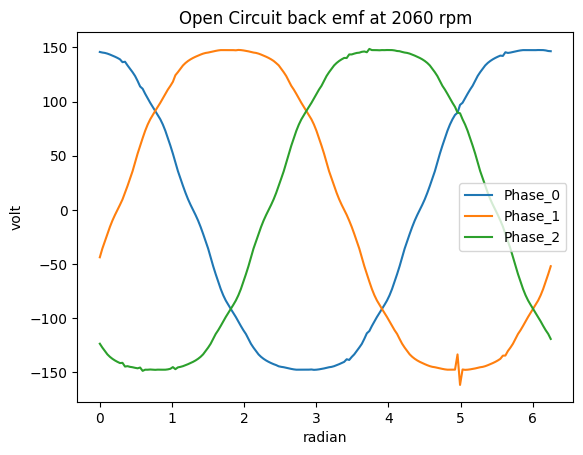

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(j1_df['angles'], j1_df['Phase_0'], label='Phase_0')
ax.plot(j1_df['angles'], j1_df['Phase_1'], label='Phase_1')
ax.plot(j1_df['angles'], j1_df['Phase_2'], label='Phase_2')
ax.legend()
ax.set_title('Open Circuit back emf at {0:~P}'.format(j1_open_cct.operating_point['simulated_speed']))

# Summary
In this example we have:
1. Created a configuration, either using Google colab secret storage, or a `configuaration.yaml` file.
2. Created a `Machine` with a Stator, Rotor, and Winding using correct units
3. Created two simulation `Jobs` with a `Machine`, an operating point, and simulation parameters,
4. Created the Jobs on the solver, and started them.
5. Waited for the simulation to finish,
6. Retrieved and plotted the back emf waveform.

This covers the very basics of using Tin Arm Engineering's machine solver API. 


In [ ]:
print(j2_nominal.id)